In [10]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

**HEART DISEASE DIAGNOSES**

**Introduction:**
 
   Heart disease is a range of conditions which affect one's cardiovascular system. The most common condition is coronary artery disease, in which plaque builds up in arteries, narrowing the vessel walls. If the buildup continues, blood will have a hard time flowing through these vessels. This condition can lead to heart attacks or strokes. Several factors influence an individual's likelihood to be diagnosed with this condition, including high blood pressure, high cholesterol, and smoking. Poor diet, excessive drinking, poor fitness, and diabetes are also factors. 
	
   Using the patient statistics in the UC Irvine University dataset, can we accurately predict the heart disease diagnoses of other patients? We will be using the aforementioned data set that lists 14 factors which influence the likelihood of heart disease, as well as the diagnoses of this patient. The diagnosis column ranges from 1-4, with 1 being no heart disease detected, and 4 being an extreme presence of the disease. We will be keeping 75% of the data for training and using 25% of it for testing. We will test the accuracy, precision and recall of the predictions that R makes, based off of this dataset. We will use a K nearest neighbor prediction calculation to test if the UC Irvine University dataset can accurately predict a diagnosis.

**Research Question:** 

Can we accurately predict if a patient has heart disease based on their age, sex, resting blood pressure, and cholesterol levels? 



**Reading The Data**

*Training Data*

In [5]:
## cp = chest pain, trestbps = resting blood pressure, fbs = fasting blood sugar > 120 mg/dl, restecg = resting electrocardiographic results
## thalach = maximum heart rate achieved, exang = exercise induced chest pain, oldpeak = ST depression induced by exercise
## slope = he slope of the peak exercise ST segment, Value 1: upsloping, Value 2: flat, Value 3: downsloping
## ca = number of major vessels(0-3), thal = 3 = normal; 6 = fixed defect; 7 = reversable defect, num = diagnosis of heart disease
set.seed(2024)
col_names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
               "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")

heart_data <- read.table("Data/processed.cleveland.data", 
                         col.names = col_names, sep = ",")


heart_data_analysis <- heart_data |> 
    select(age, chol, trestbps, num)

heart_data_split <- initial_split(heart_data_analysis, prop = 0.75, strata = num)
heart_data_train <- training(heart_data_split)
heart_data_test <- testing(heart_data_split)

heart_data_train

age,chol,trestbps,num
<dbl>,<dbl>,<dbl>,<int>
63,233,145,0
37,250,130,0
41,204,130,0
⋮,⋮,⋮,⋮
55,205,128,3
59,176,164,3
57,131,130,3


**Preliminary Exploratory Data Analysis:**

We have summarized the chosen data into two tables. One that contains the averages for the variables of age, chol and trestbps as these values have more variability and another table that contains the variables for sex and the heart disease diagnosis as these two variables have data values that fall into a few distinct levels. 

*Below is the table for the mean of the columns that we selected age, chol, and resting blood pressure*

In [6]:
column_mean <- heart_data_train |> 
    select(age, chol, trestbps)|> 
    map_df(mean)
column_mean

age,chol,trestbps
<dbl>,<dbl>,<dbl>
54.57778,247.9111,131.32


From the table we can see that all three cholesterol, resting blood pressure, and age all have a significantly different average, therefore, their values would also vary and have a wide range. We would need to scale all three predicators in order for our classificatioin model to be accurate.

*Below is the table of the spread of the different scales of diagnosis of heart disease*


In [7]:
num_counts <- heart_data_train |> 
    group_by(num) |> 
    count()
num_counts

num,n
<int>,<int>
0,122
1,42
2,26
3,26
4,9


From this table we can see that the data points are not spread out equally. The majority of the class has a 0 rating of heart disease. Therefore, in order to perform classification accurately we would need to scale-up the data first. 

**Initial Visualizations**

*Below are the histogram plots that represents each of the three numerical factors against the diagnosis of heart diseases*

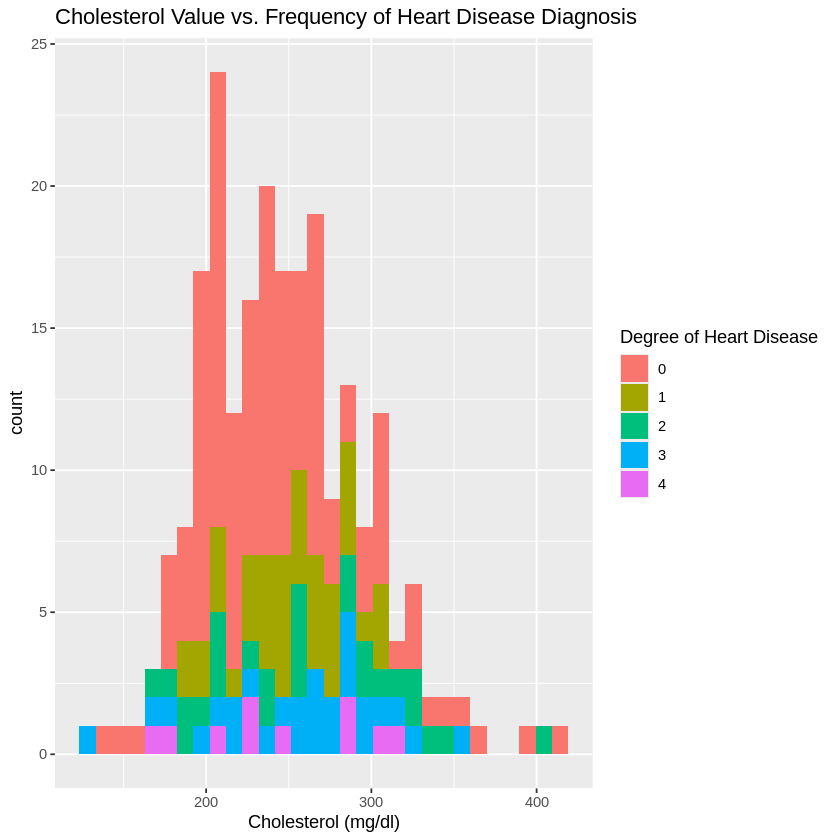

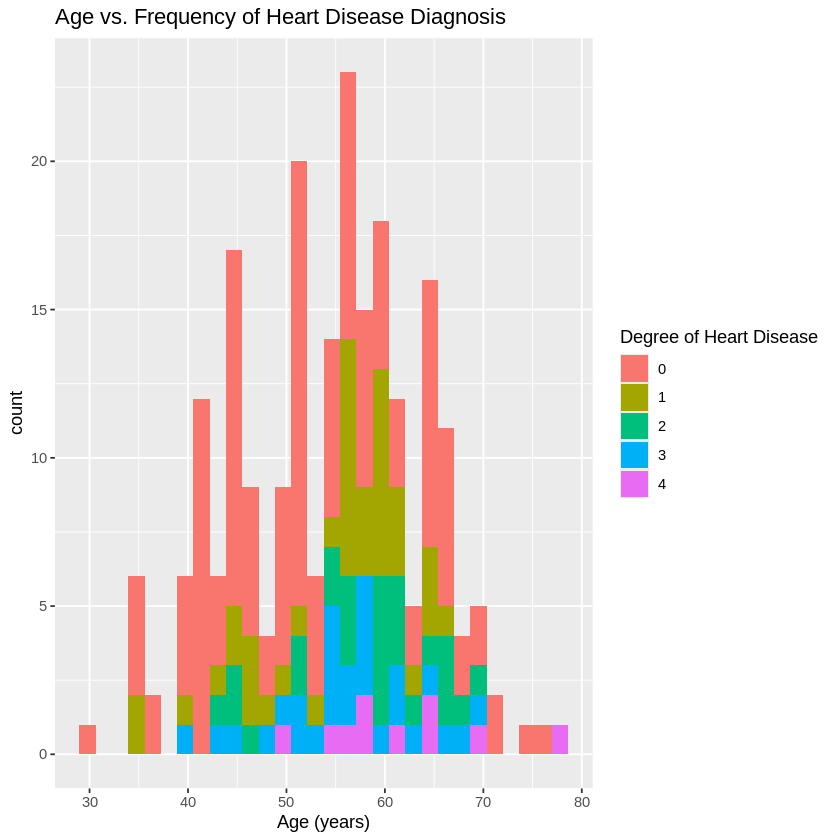

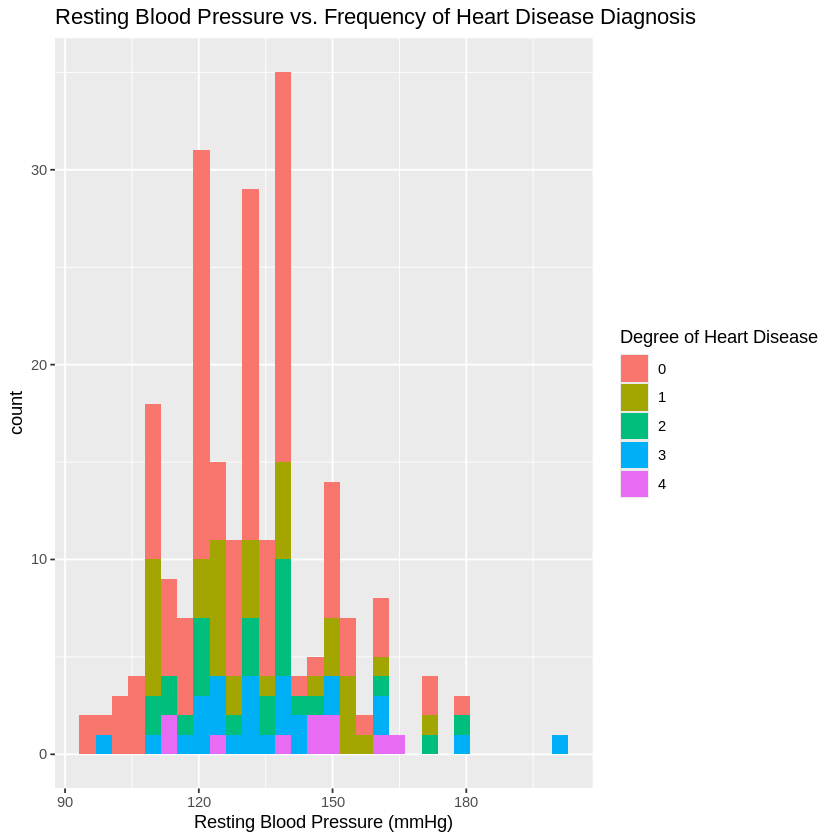

In [6]:
chol_trend_graph <- heart_data_train |> ggplot(aes(x = chol, fill = factor(num))) + 
    geom_histogram(bins = 30) +
    labs(x = "Cholesterol (mg/dl)", 
         title = "Cholesterol Value vs. Frequency of Heart Disease Diagnosis", 
         fill = "Degree of Heart Disease")

age_trend_graph <- heart_data_train |> 
    ggplot(aes(x = age, fill = factor(num))) + 
    geom_histogram(bins = 30) + 
    labs(x = "Age (years)", 
         title = "Age vs. Frequency of Heart Disease Diagnosis", 
         fill = "Degree of Heart Disease")

trestbps_trend_graph <- heart_data_train |> 
    ggplot(aes(x = trestbps, fill = factor(num))) + 
    geom_histogram(bins = 30) + 
    labs(x = "Resting Blood Pressure (mmHg)", 
         title = "Resting Blood Pressure vs. Frequency of Heart Disease Diagnosis", 
         fill = "Degree of Heart Disease")

chol_trend_graph
age_trend_graph
trestbps_trend_graph

**Analysis**

Cholesterol plot - we can see that the most diagnoses of heart disease from all levels, including diagnoses of no heart disease, fall around the 200 to 300 mg/dl range. Therefore, indicating that heart disease may also be influenced by other factors. 

Age - From the graph we can see that the amount of heart disease diagnoses for levels 1-4 tend to increase as age increases up till around age 60 before it starts declining. We can thus suspect a positive relationship between the variables up to a certain age. 

Resting Blood Pressure - looking at the highest severities, 3 and 4, of heart disease diagnosis, we observe that they are spread relatively equally between the intervals of Resting Blood Pressure, with slightly more diagnoses being made between 120 and 150 mmHg, which is higher than the ideal resting heart rates of people.

**Methods:**

We have cleaned the data by processing missing values and rendering it into tidy format. We have also split 75% of the data for training while keeping 25% for testing. We will proceed by scaling and centering the predictor variables and selecting the 4 columns that we will use to predict a diagnosis: age, sex, trestbps and chol, as well as the diagnosis column: num. We will then create a recipe and workflow for prediction, find out the optimal K through cross-validation and perform a K-nearest neighbor prediction using the optimal K and testing data as the "new" observations. After which, this prediction will be compared to the patient's actual status to calculate the accuracy, precision, and recall of the predictions based on the data from the database. Results will be visualised through a few scatterplots of the various predictor variables against heart disease diagnosis levels.


**Expected Outcomes and Significance:**

We expect to find that this dataset can accurately predict the heart disease diagnosis of patients. This result would be significant since hospitals could compare patient data to this database in order to flag potential sufferers of heart disease. This could lead to a much faster diagnosis which would allow individuals to start management and treatment for the disease earlier. Since the disease would be caught earlier on, its mortality rate would potentially decrease which would save the lives of so many people. Should this data set be accurate in predicting heart disease diagnosis, the question that should be raised is whether such predictive diagnosis can be done for other chronic diseases such as respiratory illnesses given an existing database of patients suffering from such diseases.




**References and Credits:**

- Janosi, A., Steinbrunn, W., Pfisterer, M., and Detrano, R. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.


